In [1]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
import importlib
import pandas as pd
from scipy.stats import norm 

from utils import checkpoint, warning
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import metrics

np.random.seed(0)

In [2]:
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(metrics);

## Global parameter optimization

In [3]:
fn = funct.bimodal
d = 100
n_chains = 5

In [4]:
# create a csv file with the optimal hyperparameters value for all possible combinations (don't need to run it each time)
# aut.get_hyperparams(fn=fn, d=d, L_init=10, output_csv='bimodal_hyperparams.cvs')

In [4]:
# load it 
df = pd.read_csv('hyperparameters/bimodal_hyperparams.cvs')
df

,algorithm,integ_scheme,eps,L
0,MCHMC_bounces,leapfrog,6.363553,11.170290
1,MCHMC_bounces,minimal_norm,14.199900,7.885920
2,MCLMC,leapfrog,6.155703,8.714649
3,MCLMC,minimal_norm,13.597001,7.619791


# Micro Canonical Hamiltonian Monte Carlo 
## Leapfrog 

In [7]:
row = df[(df['algorithm'] == 'MCHMC_bounces') & (df['integ_scheme'] == 'leapfrog')]
eps = row['eps'].values[0]
L = row['L'].values[0]

X, ess_mean, ess_min, ess_truth = MCHMC.MCHMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.leapfrog)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.30it/s]


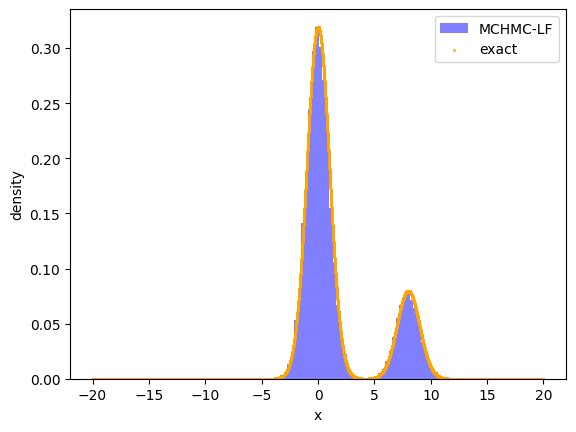

In [8]:
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/bimodal_hamiltonian_LF.svg', format='svg')
plt.show()

In [9]:
print(f'ESS with MCHMC-bounces and LF integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCHMC-bounces and LF integrator 
 mean: 0.039 
 min: 0.039 
 ground truth: 0.039


## Minimal norm

In [45]:
row = df[(df['algorithm'] == 'MCHMC_bounces') & (df['integ_scheme'] == 'minimal_norm')]
eps = row['eps'].values[0]
L = row['L'].values[0]

X, ess_mean, ess_min, ess_truth = MCHMC.MCHMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.minimal_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:10<00:00, 70.87it/s]


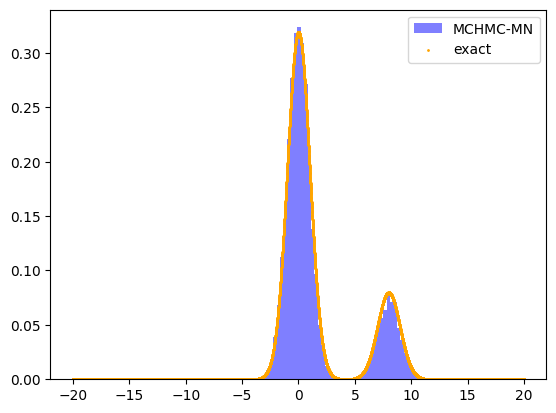

In [46]:
X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-MN')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/bimodal_hamiltonian_MN.svg', format='svg')
plt.show()

In [47]:
print(f'ESS with MCHMC-bounces and MN integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCHMC-bounces and MN integrator 
 mean: 0.397 
 min: 0.224 
 ground truth: 0.036


---------
# Langevin Like Hamiltonian Monte Carlo 
## Leapfrog

In [10]:
row = df[(df['algorithm'] == 'MCLMC') & (df['integ_scheme'] == 'leapfrog')]
eps = row['eps'].values[0]
eps = torch.tensor(eps, device=utils.choose_device())
L = row['L'].values[0]
L = torch.tensor(L, device=utils.choose_device())

X, ess_mean, ess_min, ess_truth = MCLMC.MCLMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.leapfrog)

/home/ubuntu/MCHMC/MCLMC.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=device)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 94.22it/s]


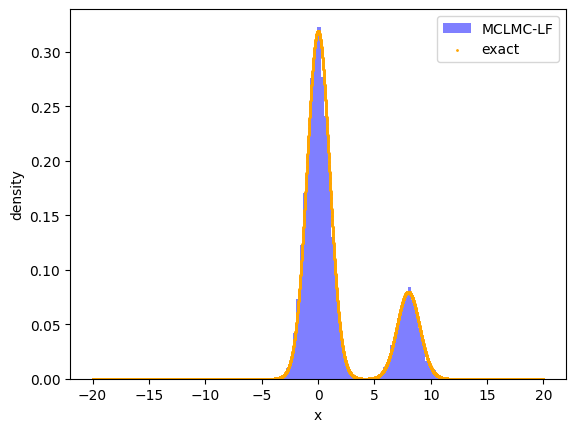

In [11]:
X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC-LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/bimodal_langevin_LF.svg', format='svg')
plt.show()

In [12]:
print(f'ESS with MCLMC and LF integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCLMC and LF integrator 
 mean: 0.076 
 min: 0.076 
 ground truth: 0.039


## Minimal norm

In [6]:
row = df[(df['algorithm'] == 'MCLMC') & (df['integ_scheme'] == 'minimal_norm')]
eps = row['eps'].values[0]
eps = torch.tensor(eps, device=utils.choose_device())
L = row['L'].values[0]
L = torch.tensor(L, device=utils.choose_device())

X, ess_mean, ess_min, ess_truth = MCLMC.MCLMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.minimal_norm)

/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ubuntu/MCHMC/MCLMC.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=device)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:09<00:00, 71.71it/s]
E0715 09:52:03.521091  326422 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.5.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0715 09:52:03.521759  326422 

In [8]:
x = np.linspace(-20, 20, 10000)
pdf = 0.8 * norm.pdf(x, 0, 1) + 0.2 * norm.pdf(x, 8, 1)

X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC-MN')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/bimodal_langevin_MN.svg', format='svg')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [17]:
print(f'ESS with MCLMC and MN integrator \n mean:  {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCLMC and MN integrator 
 mean:  0.247 
 min: 0.247 
 ground truth: 0.039
